In [59]:
%matplotlib inline
import os
import time
import warnings

from copy import deepcopy
from glob import glob
from pprint import pprint
from PIL import Image
from PIL import ImageFile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as F

from scipy.ndimage import zoom
from torch.utils.data import DataLoader
from tqdm import tqdm


ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')

In [60]:
index_dir = os.path.join('data', 'dataset', 'index')
features_dir = os.path.join('data', 'features', 'densenet161')

if not os.path.exists(features_dir):
    os.makedirs(features_dir)

classes = list(map(lambda x: os.path.basename(x), 
               glob(os.path.join(index_dir, '*'))))

dataset = {}
queries = {}
query_set = [
    '1562305641_7e37719fc0',
    '114170569_6cbdf4bbdb',
    '406697077_61287601aa',
    '2104774157_851e88c499',
    '4504777676_83db8bcd56'
]

for path in glob(os.path.join(index_dir, '*', '*')):
    image_name = os.path.basename(path).split('.')[0]
    dataset[image_name] = {
        'path': path,
        'features': None,
        'class': None
    }

for path in glob(os.path.join(features_dir, '*')):
    image_name = os.path.basename(path).split('.')[0]
    features, class_name = np.load(path, allow_pickle=True)
    dataset[image_name]['features'] = features
    dataset[image_name]['class'] = class_name
    
for image_name in query_set:
    queries[image_name] = {
        'features': dataset[image_name]['features'],
        'ranking': [],
        'class': dataset[image_name]['class']
    }

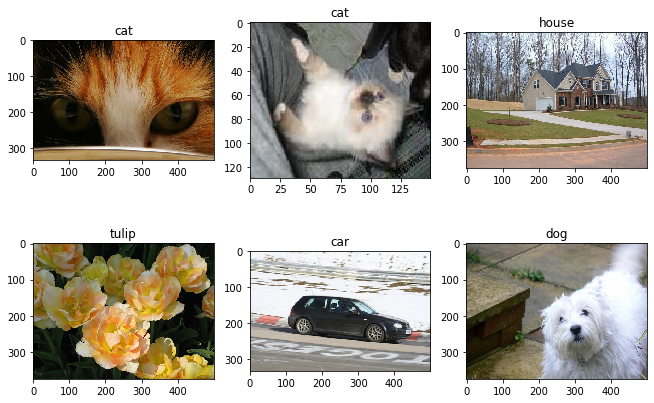

In [61]:
fig = plt.figure(figsize=(11, 11))
for i in range(0, len(images), 30):
    path = images[i]
    class_name = path.split('/')[-2]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    ax = fig.add_subplot(3, 3, i//30 + 1)
    ax.set_title(class_name, fontdict={'fontsize': 'large'})
    ax.imshow(image)
    
plt.show()

In [62]:
for qkey, qvals in queries.items():
    ranking = []
    qfeatures = qvals['features']
    for dkey, dvals in tqdm(dataset.items()):
        dfeatures = dvals['features']
        distance = np.linalg.norm(qfeatures-dfeatures)
        ranking.append([distance, dkey])
    queries[qkey]['ranking'] = sorted(ranking, key=lambda x: x[0])

100%|██████████| 157/157 [00:00<00:00, 11941.13it/s]


In [63]:
queries.keys()

dict_keys(['1562305641_7e37719fc0', '114170569_6cbdf4bbdb', '406697077_61287601aa', '2104774157_851e88c499', '4504777676_83db8bcd56'])

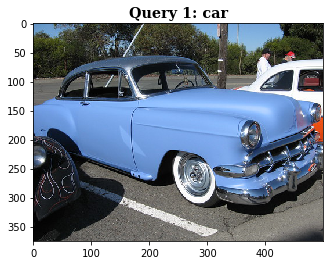

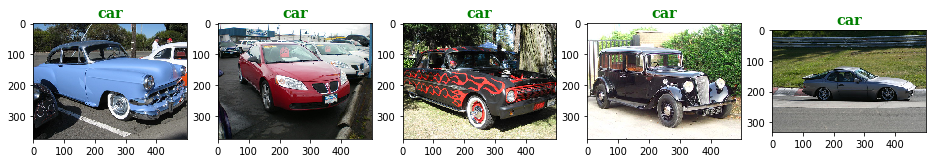

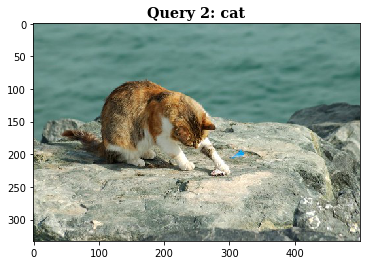

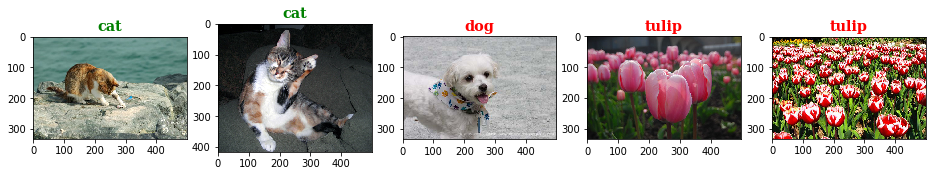

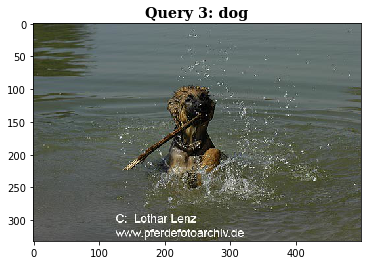

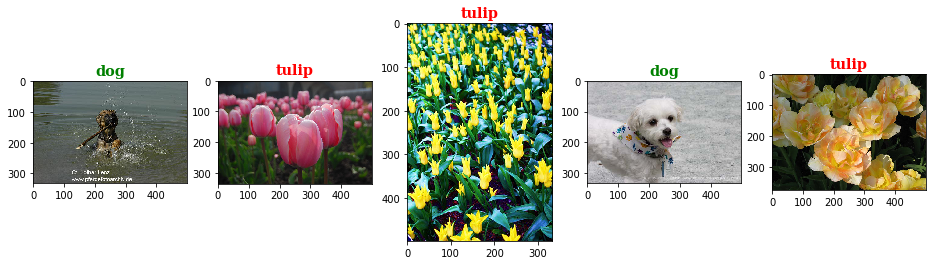

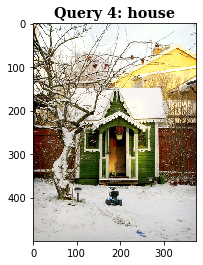

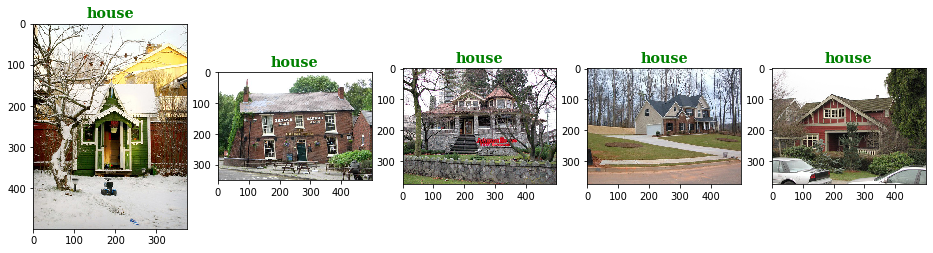

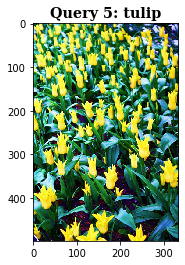

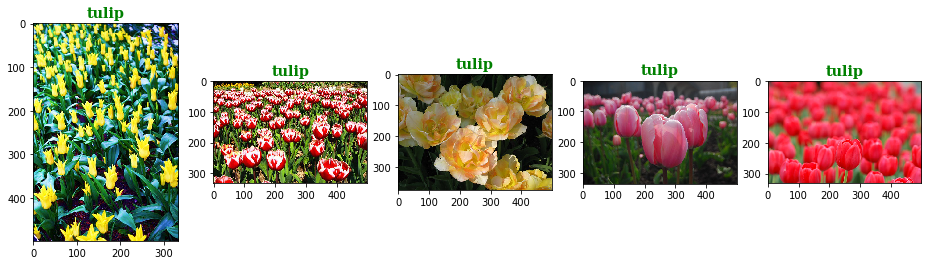

In [64]:
# Lets see which images we got
fontdict = {
    'fontsize': 'x-large',
    'fontweight': 'bold',
    'family': 'serif'
}
for i, (image_name, qvals) in enumerate(queries.items()):
    fig, ax = plt.subplots(1,1, figsize=(16,4))
    ranking = qvals['ranking']
    qimage_path = dataset[image_name]['path']
    qclass = dataset[image_name]['class']
    image = cv2.imread(qimage_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fontdict['color'] = 'black'
    ax.set_title(f'Query {i+1}: {qclass}', fontdict=fontdict)
    ax.imshow(image)
    
    fig, axs = plt.subplots(1,5, figsize=(16,4))
    for j, (distance, dbimage_name) in enumerate(ranking[:5]):
        dbimage = dataset[dbimage_name]['path']
        dbclass = dataset[dbimage_name]['class']
        image = cv2.imread(dbimage, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = axs[j]
        
        if qclass == dbclass:
            fontdict['color'] = 'green'
        else:
            fontdict['color'] = 'red'
        
        ax.set_title(dbclass, fontdict=fontdict)
        ax.imshow(image)